In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import soundfile as sf

In [2]:
def butter_lowpass_filter(data, cutoff, fs, order=12):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

In [3]:
def butter_highpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = lfilter(b, a, data)
    return y

In [4]:
def match_length(x1, target_length):
    current_length = len(x1)
    
    # Calculate the number of repetitions needed to match the target length
    repetitions = -(-target_length // current_length)  # Equivalent to ceil(target_length / current_length)
    
    # Repeat x1 to match the target length
    matched_x1 = np.tile(x1, repetitions)[:target_length]
    
    return matched_x1

In [5]:
def plot_stft_with_lowpass(audio_file, title, ax, cutoff_frequency=None):
    # Load the audio file with a specific sampling rate
    y, sr = librosa.load(audio_file, sr=44100)
    y=match_length(y,1313102)#,1976621) # => length of original music recording

    # for noise files
    y_highpass = butter_highpass_filter(y,8000, sr)
    y_filt = y + 5*y_highpass
    sf.write(f"{title}_hf_emph.wav", y_filt,sr) # audio write
        
    # Calculate the STFT for the filtered signal
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_filt)), ref=np.max)

    # Display the STFT
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(f"{title}=>{len(y)}")
    return y_filt

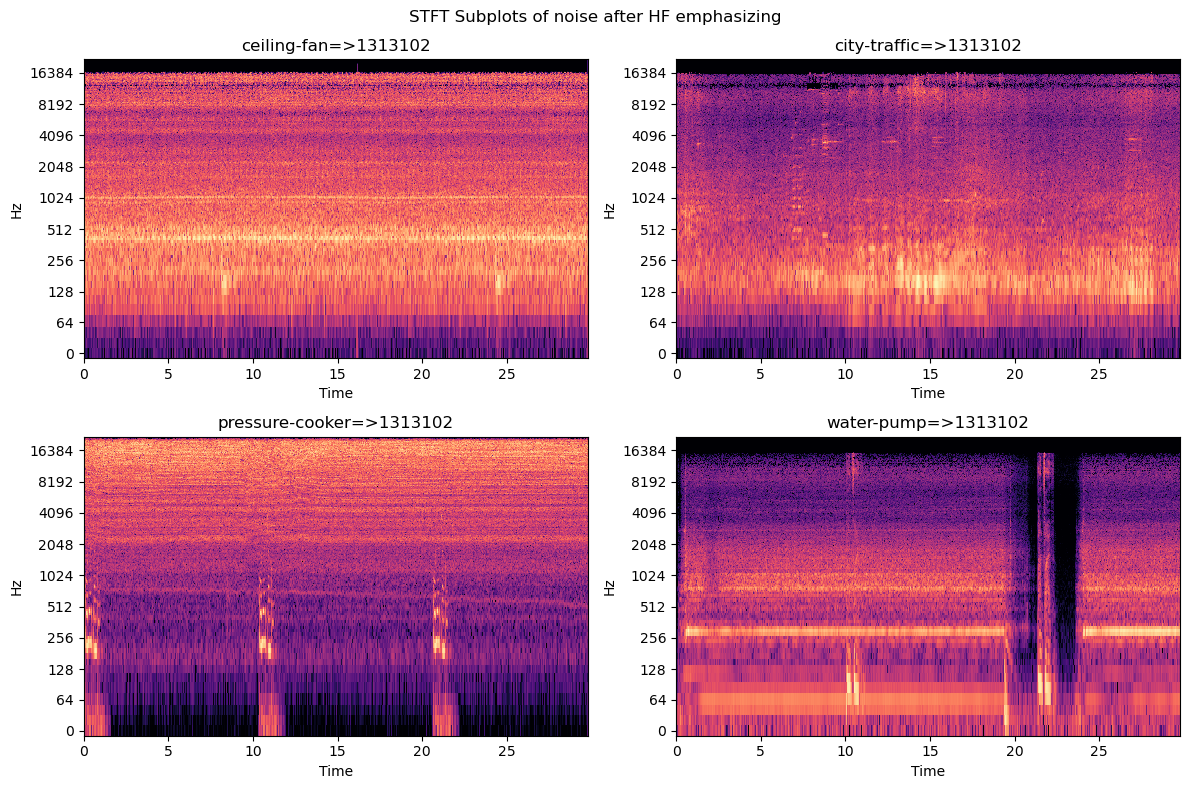

In [6]:
# List of audio files
audio_files = [
    "./ceiling-fan.mp3",
    "./city-traffic.mp3",
    "./pressure-cooker.mp3",
    "./water-pump.wav",
]

# Create a 2x2 subplot for the first five audio files
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("STFT Subplots of noise after HF emphasizing")

filtered=[]
for i in range(4):
    title = audio_files[i].split("/")[-1].split(".")[0]  # Extract the title from the file path
    temp = plot_stft_with_lowpass(audio_files[i], title, axs[i // 2, i % 2])
    filtered.append(temp)
fig.tight_layout()
plt.show()

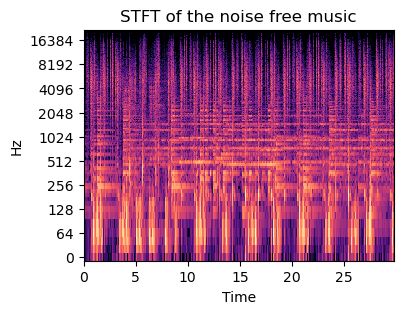

In [7]:
y, sr = librosa.load("../5-MB-WAV.wav", sr=44100)
plt.figure(figsize=(4,3))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log');
plt.title("STFT of the noise free music");

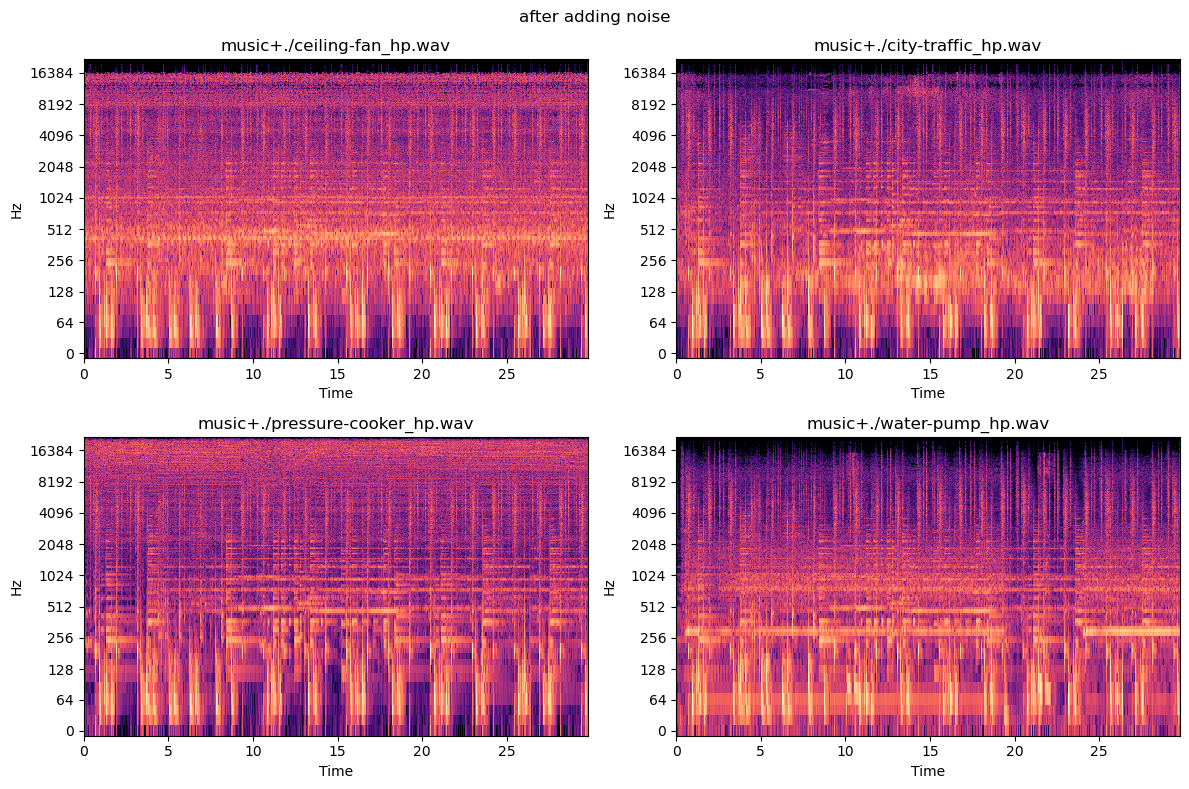

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
t=0
music, sr = librosa.load("../5-MB-WAV.wav", sr=44100)
for temp in ["./ceiling-fan_hp.wav","./city-traffic_hp.wav","./pressure-cooker_hp.wav","./water-pump_hp.wav"]:
    #filtered[t] is pre-emphasized ( high frequnecy components enhanced)
    x = music + (filtered[t]) * max(music) / max(filtered[t])
    plt.subplot(2,2,t+1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log');
    sf.write(f"music_{temp[2:]}",x,sr) # audio write
    plt.title(f"music+{temp}")
    t+=1
plt.suptitle("after adding noise");
plt.tight_layout()
plt.show()

In [9]:
def divide_signal(signal,sampling_frequency):
    time = np.arange(0, len(signal)/44100, 1/sampling_frequency)  # Time array from 0 to 45 seconds

    # Define time intervals
    interval_1 = (0, 10)  # 0-30 seconds
    interval_2 = (10, 20)  # 30-40 seconds
    interval_3 = (20, 30)  # 40 seconds to end

    # Convert time intervals to sample indices
    index_1 = np.where((time >= interval_1[0]) & (time < interval_1[1]))[0]
    index_2 = np.where((time >= interval_2[0]) & (time < interval_2[1]))[0]
    index_3 = np.where((time >= interval_3[0]) & (time <= interval_3[1]))[0]

    # Extract signals based on indices
    signal_1 = signal[index_1]
    signal_2 = signal[index_2]
    signal_3 = signal[index_3]
    return signal_1,signal_2,signal_3

In [10]:
def decrease_hf(signal_1):
    signal_1_lp  = butter_lowpass_filter(signal_1,8000,44100,order =12 )
    signal_1_hp  = butter_highpass_filter(signal_1,8000,44100,order =12 )
    array1=signal_1_lp+0.1*signal_1_hp
    return array1

In [11]:
def emph_noise(signal_2,noise_file):
    
    signal_2_lp  = butter_lowpass_filter(signal_2,8000,44100,order =12 )
    noise, sr = librosa.load(f"{noise_file[:-7]}_hf_emph.wav", sr=44100)
    noise = match_length(noise,len(signal_2))
    array2 =signal_2_lp+ 0.5*((noise)* max(signal_2) / max(noise))
    return array2

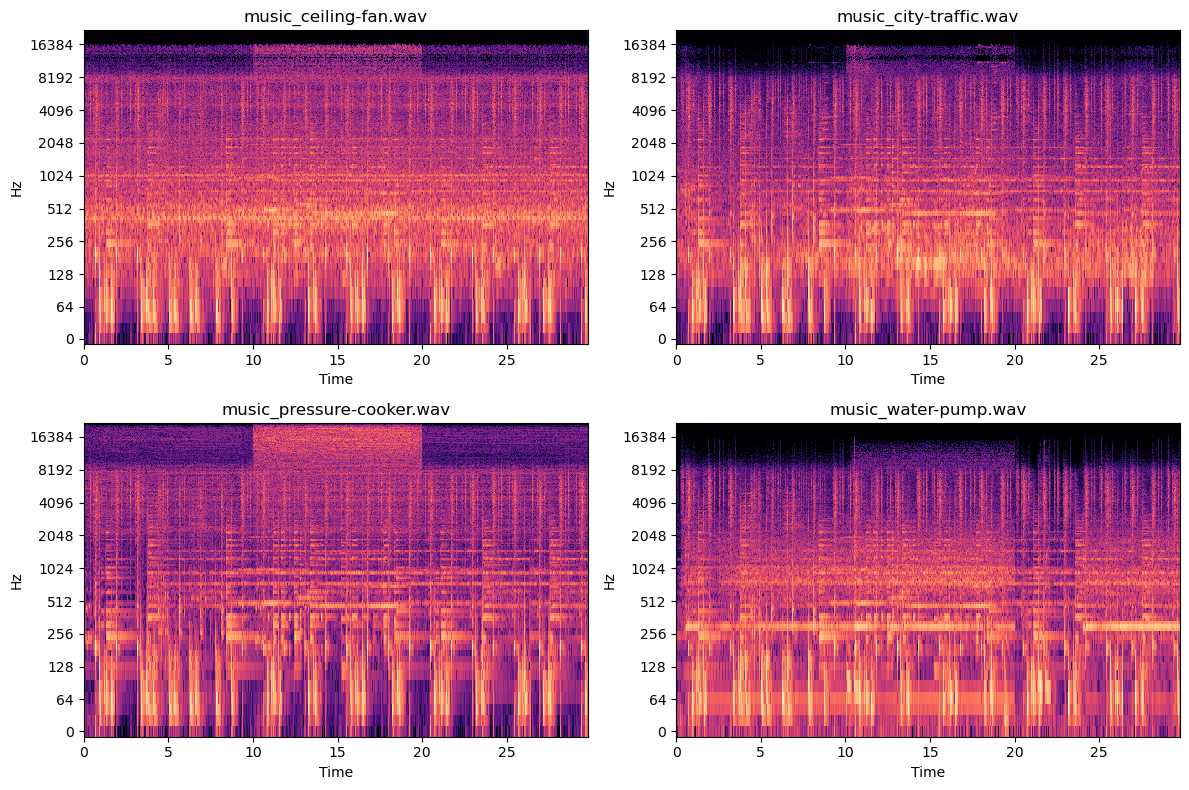

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
t=0
for temp in ["./ceiling-fan_hp.wav","./city-traffic_hp.wav","./pressure-cooker_hp.wav","./water-pump_hp.wav"]:

    music_noise, sr = librosa.load(f"music_{temp[2:]}", sr=44100)
    signal_1,signal_2,signal_3 = divide_signal(music_noise,sr)
    
    # de-emphasize hf in start and end frames
    array1 = decrease_hf(signal_1)
    array3 = decrease_hf(signal_3)
    
    # emphasize hf of noise in middle frames
    array2 = emph_noise(signal_2,temp)
    
    x = np.concatenate((array1, array2, array3))
    plt.subplot(2,2,t+1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log');
    sf.write(f"./final_folder/music_{temp[2:-7]}.wav",x,sr) # audio write
    plt.title(f"music_{temp[2:-7]}.wav")
    t+=1
plt.tight_layout()

In [13]:
for temp in ["./ceiling-fan_hp.wav","./city-traffic_hp.wav","./pressure-cooker_hp.wav","./water-pump_hp.wav"]:
    music_noise, sr = librosa.load(f"./final_folder/music_{temp[2:-7]}.wav", sr=44100)

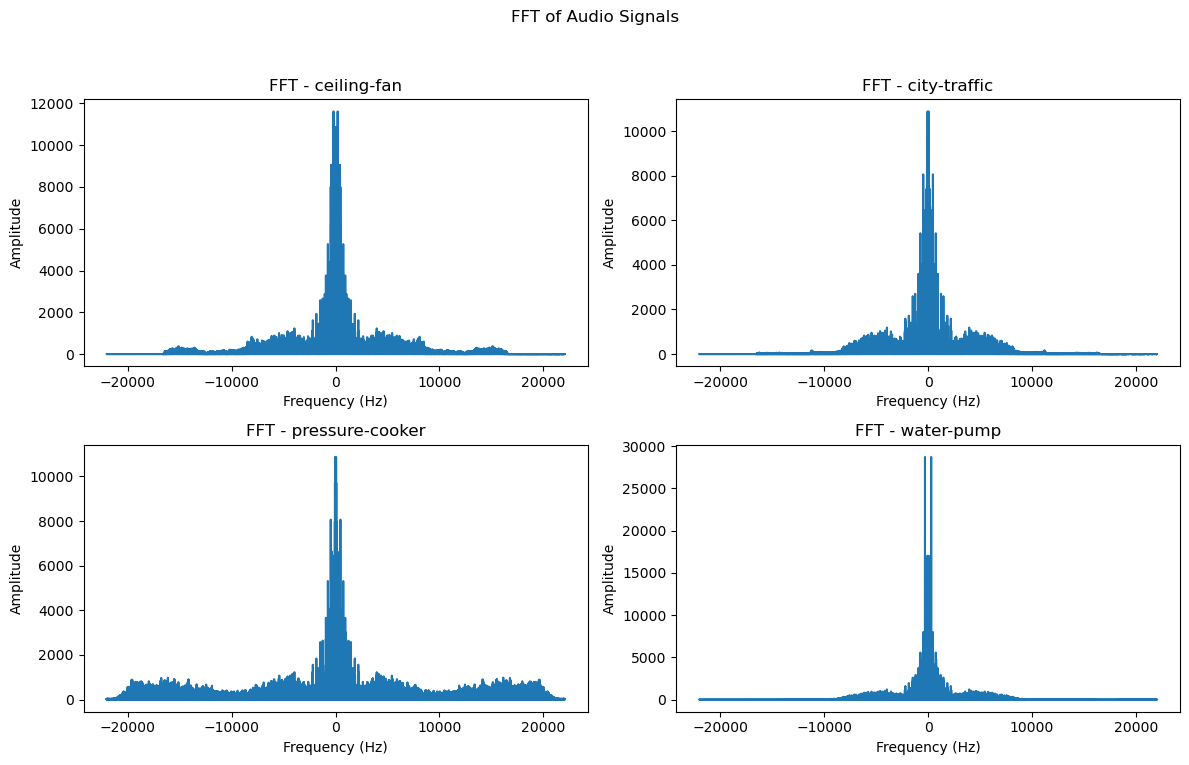

In [14]:
audio_files = ["./ceiling-fan_hp.wav", "./city-traffic_hp.wav", "./pressure-cooker_hp.wav", "./water-pump_hp.wav"]

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("FFT of Audio Signals")

for i, file_path in enumerate(audio_files):
    # Load audio file
    audio_signal, sr = librosa.load(f"./final_folder/music_{file_path[2:-7]}.wav", sr=44100)

    # Compute FFT
    fft_result = np.fft.fft(audio_signal)
    fft_freq = np.fft.fftfreq(len(fft_result), 1/sr)

    # Plot in the ith subplot
    axs[i//2, i%2].plot(fft_freq, np.abs(fft_result))
    axs[i//2, i%2].set_title(f"FFT - {file_path[2:-7]}")
    axs[i//2, i%2].set_xlabel("Frequency (Hz)")
    axs[i//2, i%2].set_ylabel("Amplitude")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

In [15]:
# y,sr = librosa.load("../5-MB-WAV.wav")
# t = np.arange(0,len(y))/sr
# plt.plot(t,y);

In [16]:
# y,sr = librosa.load("./ipl-9284.wav")
# t = np.arange(0,len(y))/sr
# plt.plot(t,y);

In [17]:
# D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
# librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log');